<a href="https://colab.research.google.com/github/DeMiKe16/RL_VLB/blob/main/mountaincar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definicion del problema

Mountain Car es un ejercicio de Gymnasium en el que el objetivo es lograr que un automóvil alcance la cima de una colina impulsándose de un valle. El agente controla el automóvil acelerando hacia la izquierda o la derecha en un entorno donde la física juega un papel clave, ya que la potencia del motor es insuficiente para subir directamente la colina, requiriendo el uso del impulso acumulado. El desafío radica en coordinar los movimientos para generar suficiente inercia y alcanzar la cima en el menor tiempo posible.  

Un episodio en Mountain Car finaliza en dos casos: si el automóvil alcanza la cima de la colina (posición ≥ 0.5) o si se superan los 200 pasos de un episodio.  

Por cada paso, se otorga recompensa en base a las siguientes reglas:  

- Se otorga una recompensa de -1 por cada paso tomado, incentivando al agente a resolver el problema en la menor cantidad de movimientos posible.  

Un episodio se considera resuelto si alcanza al menos -110 puntos en un promedio de 100 episodios.

# Autores
- Alejandro López Cuéllar
- Miguel Ángel Vera Frutos
- Alejandro Belda Fernández


# Importar librerías

In [ ]:
! git clone https://github.com/DeMiKe16/RL_VLB.git

Cloning into 'RL_VLB'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 152 (delta 55), reused 45 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 20.06 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
!  pip install numpy matplotlib tqdm gymnasium moviepy torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random
from gymnasium import ObservationWrapper
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip  # Import from correct locationimport torch
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import torch.optim as optim
import os
import gc
from collections import defaultdict

# Reproducibilidad

In [ ]:
semilla = 42
np.random.seed(semilla)
np.random.default_rng(semilla)
random.seed(semilla)
os.environ['PYTHONHASHSEED'] = str(semilla)
torch.manual_seed(semilla)
if torch.cuda.is_available():
    torch.cuda.manual_seed(semilla)
    torch.cuda.manual_seed_all(semilla)  # Para múltiples GPUs

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [ ]:
gc.collect()

30

# Metodos Auxiliares

Este metodo nos genera una política óptima (`pi_star`) a partir de una función de valor de acción `Q(o los weights)` en un entorno (en este caso el Mountain Car), recorriendo el ambiente desde un estado inicial hasta que se alcanza un estado terminal o se trunca el episodio. Se inicializa el entorno con una semilla (que falta definir), y en cada paso, se selecciona la acción con el mayor valor Q calculado a partir de las características activas del estado actual. Se almacena la política óptima en un diccionario, registra la secuencia de acciones tomadas en una cadena y guarda las imágenes renderizadas en `frames`. Finalmente, devuelve la política óptima, la secuencia de acciones y la lista de imágenes del episodio.

In [ ]:
def pi_star_from_Q(env, Q):  # Add seed parameter
    frames = []
    done = False
    pi_star = {}
    obs, info = env.reset(seed = semilla)
    active_features = env.last_active_features
    img = env.render()
    frames.append(img)
    actions = ""
    while not done:
        q_values = [np.sum(Q[active_features, a]) for a in range(env.action_space.n)]
        action = np.argmax(q_values)
        pi_star[tuple(obs)] = action
        actions += f"{action}, "
        obs, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)
        done = terminated or truncated
        active_features = env.last_active_features
    return pi_star, actions, frames

El metodo `plot` se encarga de generar gráficos para analizar el rendimiento de un agente de aprendizaje por refuerzo. Calcula la media móvil de la proporción de recompensas obtenidas y del tamaño de los episodios usando una ventana deslizante (`window_size`) para suavizar las fluctuaciones. Luego, en un gráfico de dos subgráficos, muestra la evolución de las recompensas y los tamaños de los episodios a lo largo del tiempo, comparando los valores originales con sus medias móviles para visualizar tendencias y estabilidad en el aprendizaje del agente. Finalmente, ajusta el diseño y muestra los gráficos.

In [ ]:
def plot(list_stats, episode_sizes, window_size=100):
    # Creamos una lista de índices para el eje x
    indices = list(range(len(list_stats)))

    # Función para calcular la media móvil
    def calculate_moving_avg(data, window_size):
        moving_avg = []
        for i in range(len(data)):
            if i < window_size:
                moving_avg.append(sum(data[:i+1]) / (i+1))
            else:
                moving_avg.append(sum(data[i-window_size:i+1]) / window_size)
        return moving_avg

    # Calculamos la media móvil para la proporción de recompensas
    moving_avg_rewards = calculate_moving_avg(list_stats, window_size)

    # Calculamos la media móvil para el tamaño del episodio
    moving_avg_sizes = calculate_moving_avg(episode_sizes, window_size)

    # Creamos el gráfico de la proporción de recompensas y la media móvil
    plt.figure(figsize=(12, 6))

    # Gráfico de la proporción de recompensas y la media móvil
    plt.subplot(2, 1, 1)
    plt.plot(indices, list_stats, label='Proporción de recompensas', alpha=0.3, color='blue')  # Más transparente
    plt.plot(indices, moving_avg_rewards, label=f'Media móvil (ventana={window_size})', color='red', linewidth=2)  # Más opaco
    plt.title('Proporción de recompensas y Media Móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.legend()
    plt.grid(True)

    # Gráfico del tamaño del episodio y su media móvil
    plt.subplot(2, 1, 2)
    plt.plot(indices, episode_sizes, label='Tamaño del episodio', alpha=0.3, color='green')  # Más transparente
    plt.plot(indices, moving_avg_sizes, label=f'Media móvil (ventana={window_size})', color='orange', linewidth=2)  # Más opaco
    plt.title('Tamaño del Episodio y Media Móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Tamaño')
    plt.legend()
    plt.grid(True)

    # Ajustamos el espacio entre los subplots
    plt.tight_layout()

    # Mostramos los gráficos
    plt.show()

El metodo `create_gif` se encarga de crear un gif a partir de una lista de imagenes, este gif sera un video en donde se ve si el agente entrenado previamente es capaz de completar el juego.

In [ ]:
def create_gif(frames: list, filename, fps=5):
   """
   Creates a GIF animation from a list of RGBA NumPy arrays.
   Args:
       frames: A list of RGBA NumPy arrays representing the animation frames.
       filename: The output filename for the GIF animation.
       fps: The frames per second of the animation (default: 10).
   """
   clip = ImageSequenceClip(frames, fps=fps)
   clip.write_videofile(filename, fps=fps)

Creamos el entorno de mountain car

In [ ]:
#@title Cargamos el entorno
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset(seed=semilla)

(array([-0.4452088,  0.       ], dtype=float32), {})

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
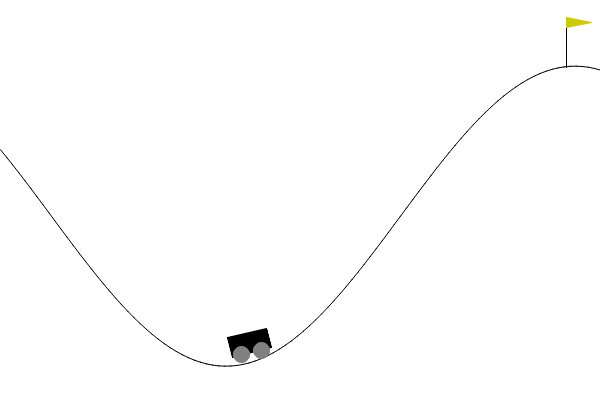

In [ ]:
env.render()

In [ ]:
env.action_space

Discrete(3)

El espaccio de acciones es el siguiente:
- 0 retroceder
- 1 no hacer nada
- 2 avanzar

In [ ]:
env.observation_space, env.observation_space.low,  env.observation_space.high

(Box([-1.2  -0.07], [0.6  0.07], (2,), float32),
 array([-1.2 , -0.07], dtype=float32),
 array([0.6 , 0.07], dtype=float32))

El espacio de observacion es el siguiente:
- Posicion en el eje x del coche: [-1.2, 0.6]
- La velocidad del coche: [-0.07, 0.07]

# Tiling Code

Tile Coding es una técnica de discretización que permite representar un espacio de estados continuo como un conjunto de tilings (rejillas superpuestas y desplazadas). Cada tiling divide el espacio en celdas discretas, y una observación activa varias celdas en diferentes tilings, permitiendo que estados cercanos compartan características y facilitando la generalización del aprendizaje. En **Control y Función de Aproximación**.

Definimos una clase que extiende gym.ObservationWrapper para aplicar Tile Coding y discretizar observaciones continuas en el entorno. Al inicializar, la clase genera varias rejillas desplazadas (tilings) que dividen el espacio de estados en celdas. Cuando el agente recibe una observación continua, la convierte en índices discretos correspondientes a las rejillas, almacenando los índices activos en self.last_active_features. La función _get_active_features() transforma estos índices en valores únicos que identifican las características activas en una representación de aprendizaje. _create_tilings() genera múltiples rejillas desplazadas al modificar ligeramente los límites del espacio de estados en cada tiling, asegurando que diferentes tilings cubran distintas regiones del espacio de estados, mejorando la generalización del aprendizaje.

In [ ]:
#@title Extensión de la clase ObservationWrapper de Gymnasium para discretizar estados continuos

env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset(seed=semilla)

# https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/


# Definimos una clase que hereda de gym.ObservationWrapper, la cual nos permite modificar las observaciones que devuelve el entorno.

class TileCodingEnv(ObservationWrapper):
    """
    TileCodingEnv es un envoltorio para un entorno Gym que aplica la técnica de Tile Coding.
    Esta técnica discretiza observaciones continuas en múltiples rejillas (tilings) desplazadas,
    permitiendo representar el espacio de estados de forma que se faciliten la generalización y el aprendizaje.
    """

    def __init__(self, env, bins, low, high, n=4):
        """
        Inicializa el entorno env con tile coding.

        Parámetros:
        - env: entorno original de Gym.
        - bins: array o lista con el número de intervalos (bins) que hay que particionar cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - n: número de tilings (rejillas) a crear (por defecto 4).

        Se llama al método _create_tilings para generar las rejillas desplazadas.
        """
        super().__init__(env)  # Llama al constructor de la clase padre ObservationWrapper.

        # Guardamos atributos útiles para calcular las features solo una vez.
        self.bins = bins              # Ej.: np.array([10, 10])
        self.n_tilings = n            # Número de tilings.
        self.tile_size = int(np.prod(bins))  # Número de celdas en cada tiling.
        self.last_active_features = None     # Aquí se guardarán las features activas de la última observación

        self._high = high
        self._low = low

        self.tilings = self._create_tilings() # (bins, high, low, n)  # Crea y almacena las tilings.

        # el vector de observación tendrá C componentes. Por ejemplo, para 2 dimensiones × 4 tilings = C = 8.
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist()*n)



    def observation(self, obs):  # Es necesario sobreescribir este método de ObservationWrapper
        """
        Transforma una observación continua en una representación discreta usando tile coding.

        Parámetro:
        - obs: observación continua proveniente del entorno.

        Para cada tiling en self.tilings, se determina el índice (bin) para cada dimensión usando np.digitize.
        Se devuelve una lista de tuplas de índices, una por cada tiling.
        Antes de retornar, se calcula y almacena en self.last_active_features el conjunto de índices
        activos (flattened) usando _get_active_features().

        Retorna:
        - indices: lista de tuplas de índices, una por cada tiling.

        """
        indices = []  # Lista que almacenará los índices discretizados para cada tiling.
        for t in self.tilings:
            # Para cada tiling 't', se calcula el índice en el que se encuentra cada componente de la observación.
            tiling_indices = tuple(np.digitize(i, b) for i, b in zip(obs, t))
            indices.append(tiling_indices)  # Se agrega la tupla de índices correspondiente a la tiling actual.

        # Calcula y guarda las features activas a partir de los índices obtenidos.
        self.last_active_features = self._get_active_features(indices)
        return indices # Retorna la lista de índices de todas las tilings.


    def _get_active_features(self, tiles):
        """
        Método privado para calcular los índices (features) activos en la función aproximada.

        Parámetro:
        - tiles: lista de tuplas (una por tiling) obtenida de observation(), donde cada tupla
          contiene los índices discretizados para cada dimensión.

        La función realiza lo siguiente:
          1. Convierte cada tupla de índices a un índice plano usando np.ravel_multi_index(tile, bins).
            - Dado que `tile` es una tupla de índices - por ejemplo, `(3, 5)` , y
            - dado que `bins` indica las particiones en cada dimensión - por ejemplo `bins = [10, 10]``
            - entonces `(3, 5)` se mapea a  3*10 + 5 = 35
            - Este índice plano identifica de forma única una celda dentro de una tiling.

          2. Asigna a cada tiling un bloque distinto en el vector de parámetros, de forma que:
             feature = (índice del tiling * tile_size) + índice plano.
             - Por ejemplo, con dos tilings, si en ambos se selecccionara el tile `(3, 5)`
             - Para el tiling 0 (i = 0), el flat_index será 35 (como se ha calculado antes)
             - Pero para el tiling 1 (i=1), el flat_index será 1*100+35=135

        Retorna:
        - features: lista de índices únicos (enteros) que indican las características activas.
        """
        features = []
        for i, tile in enumerate(tiles):
            # Convierte la tupla 'tile' a un índice plano.
            flat_index = np.ravel_multi_index(tile, self.bins)
            # Asigna a cada tiling un bloque único: para el tiling i, los índices van desde i*tile_size hasta (i+1)*tile_size - 1.
            feature = i * self.tile_size + flat_index
            features.append(feature)
        return features



    def _create_tilings(self): # , bins, high, low, n):
        """
        Crea 'n' tilings (rejillas) desplazadas para el tile coding.

        Parámetros:
        - bins: número de intervalos (bins) en cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - n: número de tilings a crear.

        El proceso consiste en:
         1. Generar un vector de desplazamientos base (displacement_vector) para cada dimensión.
         2. Para cada tiling, se ajustan los límites 'low' y 'high' añadiéndoles un pequeño desplazamiento aleatorio.
         3. Se calculan los tamaños de los segmentos en cada dimensión (segment_sizes).
         4. Se determinan desplazamientos específicos para cada dimensión y se aplican a los límites.
         5. Finalmente, se generan los buckets (límites discretos) para cada dimensión usando np.linspace.

        Retorna:
        - tilings: una lista donde cada elemento es una tiling (lista de arrays de buckets para cada dimensión).
        """
        # Se genera un vector de desplazamientos en cada dimensión en base a los números impares.
        # P.e. Si hay 2 dimensiones (len(bins) == 2): np.arange(1, 2 * 2, 2) -> np.arange(1, 4, 2) devuelve [1, 3]
        #      Si la dimensión 1 se desplaza en 1 unidad, en la dimensión 2 se desplazará en 3 unidades.
        # P.e. Si hay 3 dimensiones (len(bins) == 3): np.arange(1, 2 * 3, 2) -> np.arange(1, 6, 2) devuelve [1, 3, 5]
        # P.e. Si hay 4 dimensiones (len(bins) == 4): np.arange(1, 2 * 4, 2) -> np.arange(1, 8, 2) devuelve [1, 3, 5, 7]
        # Y así sucesivamente.
        # displacement_vector se ajusta automáticamente generando un array de números impares
        # Estos valores se usan posteriormente para calcular los desplazamientos específicos en cada dimensión al crear las tilings (rejillas).
        # ¿Por qué esos valores? Porque son los recomendados: los primeros números impares.
        displacement_vector = np.arange(1, 2 * len(bins), 2)


        tilings = []  # Lista que almacenará todas las tilings generadas.
        for i in range(0, self.n_tilings):
            # Para cada tiling 'i', se calculan nuevos límites 'low_i' y 'high_i' con un desplazamiento aleatorio.
            # El desplazamiento aleatorio se basa en el 20% de los límites originales.
            low_i = self._low  # - random.random() * 0.2 * low
            high_i = self._high # + random.random() * 0.2 * high

            # Vamos a calcular el desplazamiento específico para cada dimensión y cada mosaico.

            # Antes calculamos displacement_vector, que nos indica el desplazamiento en cada dimensión.
            # Como tenemos varios mosaicos, cada uno se tendrá que desplazar
            # en la mismas cantidades con respecto al mosaico anterior.
            # Esto se puede conseguir multiplicando el displacement_vector por el número de mosaico (i),
            # pero se toma el módulo n (número total de mosaicos).
            # De esta forma el desplazamiento de cada mosaico es diferente, dentro del rango [0, n-1]

            # P.e. Para n=4 mosaicos, y dos dimensiones, los vectores de desplazamiento de cada mosaico son:
            # i = 1: [1, 3] = [1, 3] * 1 % 4 = [1, 3] % 4
            # i = 2: [2, 2] = [1, 3] * 2 % 4 = [2, 6] % 4
            # i = 3: [3, 1] = [1, 3] * 3 % 4 = [3, 9] % 4
            # i = 4: [0, 0] = [1, 3] * 4 % 4 = [4, 12] % 4
            displacements = displacement_vector * i % self.n_tilings

            # Pero hay que escalar el desplazamiento a unidades reales en cada dimensión.
            # Para ello necesitamos calcular el tamaño de cada segmento (intervalo) en cada dimensión.
            segment_sizes = (high_i - low_i) / self.bins

            # Entonces usamos una fracción del tamaño del segmento para desplazar cada mosaico.
            # La fracción del tamaño del segmento viene dado por el tamaño del segmento dividido por el número de mosaicos.
            # Por ejemplo, si el tamaño de la celda es 0.5 en la primera dimensión y se consideran n=4 mosaicos, la fracción es 0.5/4=0.125
            # Según se ha calculado anteriormente, en el vector de desplazamiento,
            # la primera dimensión se desplaza en 1, 2, 3 y 0 unidades para los mosaicos 1, 2, 3, y 4, respectivamente.
            # Como la unidad es 0.125, entonces la primera dimensión de cada mosaico se desplaza en las cantidades:
            # 0.125 = 1 * 0.125,  0.25 = 2 * 0.125, 0.375 = 3 * 0.125, y  0 = 0 * 0.125.
            # Lo mismo se haría con el resto de dimensiones. En forma vectorial:
            # Es decir, el desplazamiento de cada mosaico en la primera dimensión es:
            # Tiling 1, [1, 3]: [1 * 0.125, 3 * 0.05] = [0.125, 0.15]
            # Tiling 2, [2, 2]: [2 * 0.125, 2 * 0.05] = [0.25, 0.10]
            # Tiling 3, [3, 1]: [3 * 0.125, 1 * 0.05] = [0.375, 0.05]
            # Tiling 4  [0, 0]: [0 * 0.125, 0 * 0.05] = [0, 0]
            displacements = displacements * (segment_sizes / self.n_tilings)

            dlow_i = low_i + displacements
            dhigh_i = high_i + displacements
            # print(f"Tiling {i}: Se aplican los desplazamientos {displacements} a los límites inferiores {low_i}->{dlow_i} y superiores {high_i}->{dhigh_i}.")

            # Para cada dimensión, se crean los buckets que dividen el intervalo de low_i a high_i en 'bins' partes,
            # generando 'l-1' puntos (límites) para cada dimensión.
            buckets_i = [np.linspace(j, k, l - 1) for j, k, l in zip(dlow_i, dhigh_i, bins)]

            # Se añade la tiling actual (lista de buckets para cada dimensión) a la lista de tilings.
            tilings.append(buckets_i)

        return tilings  # Retorna la lista completa de tilings.

Realizamos la discretizacion

In [ ]:
#@title Generamos  mosaicos (tilings) con varios intervalos por dimensión. Al nuevo espacio lo llamaremos *tcenv*
tilings = 10  # Número de mosaicos
bins = np.array([20, 20])  # Número de intervalos en cada dimensión. 20 en cada una
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

Comparamos el entorno original con el entorno con estados agregados

In [ ]:
#@title Comparamos el entorno original con el entorno con estados agregados

print(f"El espacio de observaciones original es: {env.observation_space}, \n\
Un estado para este espacio original es: {env.step(env.action_space.sample())}")
print(f"\nEl espacio de estados modificado es: {tcenv.observation_space}. Mosaicos: {tcenv.n_tilings} \n\
Un estado para este nuevo espacio es: {tcenv.step(tcenv.action_space.sample())[0]} \n\
Cada pareja es la 'celda' correspondiente a cada mosaico")
print(f"Las caracterísiticas observadas han sido {tcenv.last_active_features} sobre {np.prod(tcenv.bins)*tcenv.n_tilings} parámetros")

El espacio de observaciones original es: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Un estado para este espacio original es: (array([-0.4457913 , -0.00058252], dtype=float32), -1.0, False, False, {})

El espacio de estados modificado es: MultiDiscrete([20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]). Mosaicos: 10 
Un estado para este nuevo espacio es: [(8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9)] 
Cada pareja es la 'celda' correspondiente a cada mosaico
Las caracterísiticas observadas han sido [169, 569, 969, 1368, 1769, 2169, 2549, 2949, 3349, 3749] sobre 4000 parámetros


# Sarsa Semi-Gradiente

**SARSA Semi-Gradiente** es un método de aprendizaje que se puedue usar cuando el espacio de estados es demasiado grande o continuo, lo que hace imposible almacenar una tabla de valores Q. En lugar de aprender directamente los valores de cada estado-acción, el algoritmo usa una función aproximadora (pesos) que estima estos valores basándose en un conjunto de parámetros ajustables. A medida que el agente explora el entorno, estos parámetros se actualizan de manera incremental utilizando descenso de gradiente, lo que permite mejorar la estimación de los valores de acción sin necesidad de almacenar todas las combinaciones posibles.

Definimos el agente

In [ ]:
class SarsaSemiGradientAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.01):
        """
        Inicializa el agente SARSA con gradiente semilineal y Tile Coding.

        Parámetros:
        - env: Entorno de Gymnasium con Tile Coding.
        - alpha: Tasa de aprendizaje.
        - gamma: Factor de descuento (importancia de recompensas futuras).
        - epsilon: Probabilidad inicial de exploración (ε-greedy).
        - epsilon_decay: Factor de reducción de epsilon por episodio.
        - min_epsilon: Límite inferior de epsilon para evitar exploración excesiva.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Número de acciones posibles en el entorno
        self.num_actions = env.action_space.n

        # Número total de características en la codificación de tiles
        self.num_features = env.n_tilings * np.prod(env.bins)

        # Matriz de pesos inicializados en 0, de tamaño [n_features, n_actions]
        self.weights = np.zeros((self.num_features, self.num_actions))

    def get_q(self, active_features, action):
        """
        Calcula el valor de Q(s, a) como la suma de los pesos de las features activas.

        Parámetros:
        - active_features: Lista de índices de características activas en el estado s.
        - action: Acción para la cual se calcula Q(s, a).

        Retorna:
        - Valor de Q(s, a) sumando los pesos correspondientes a las características activas.
        """
        return np.sum(self.weights[active_features, action])

    def choose_action(self, active_features):
        """
        Selecciona una acción usando la estrategia ε-greedy.

        Parámetros:
        - active_features: Lista de índices de características activas en el estado actual.

        Retorna:
        - Acción seleccionada (exploratoria o explotadora).
        """
        if np.random.rand() < self.epsilon:
            # Exploración: Selecciona una acción aleatoria con probabilidad ε
            return np.random.choice(self.num_actions)
        else:
            # Explotación: Selecciona la acción con el mayor valor Q estimado
            q_values = [np.sum(self.weights[active_features, action]) for action in range(self.num_actions)]
            return np.argmax(q_values)

    def decay_epsilon(self):
        """
        Reduce el valor de epsilon para disminuir la exploración con el tiempo.
        Se asegura de que epsilon no caiga por debajo de min_epsilon.
        """
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

    def update(self, active_features, active_features_next, a, a_next, reward, done, truncated):
        """
        Realiza la actualización de los pesos usando la ecuación de actualización de SARSA.

        Parámetros:
        - active_features: Lista de características activas en el estado actual.
        - active_features_next: Lista de características activas en el próximo estado.
        - a: Acción tomada en el estado actual.
        - a_next: Acción tomada en el próximo estado.
        - reward: Recompensa obtenida por tomar la acción a en el estado actual.
        - done: Indica si se llegó al estado terminal.
        - truncated: Indica si el episodio se truncó por un límite de pasos.

        """
        # Calcular Q(s,a) para el estado actual y la acción tomada
        q_sa = self.get_q(active_features, a)

        # Si no es estado terminal, calcular Q(s',a')
        if not (done or truncated):
            q_sap = self.get_q(active_features_next, a_next)
            delta = reward + self.gamma * q_sap - q_sa  # Error de TD
        else:
            delta = reward - q_sa  # En estado terminal, Q(s', a') no contribuye

        # Actualizar los pesos solo en las features activas para la acción 'a'
        for i in active_features:
            self.weights[i, a] += self.alpha * delta  # Regla de actualización de SARSA





Definimos hiperparámetros para el agente que le permitan obtener una solución

In [ ]:
# Hiperparámetros
num_episodes = 20000  # Número total de episodios de entrenamiento
GAMMA = 0.99  # Factor de descuento: importancia de las recompensas futuras (0 a 1)
ALPHA = 0.1  # Tasa de aprendizaje: cuánto se ajustan los pesos en cada actualización
EPSILON = 1.0  # Probabilidad de exploración inicial (epsilon-greedy)
EPSILON_DECAY = 0.999  # Factor de decaimiento de epsilon: reduce la exploración con el tiempo
MIN_EPSILON = 0.01  # Valor mínimo de epsilon: asegura una mínima exploración continua
max_steps = 200  # Número máximo de pasos por episodio

Inicializamos el agente

In [ ]:
# Inicializar el agente
agent = SarsaSemiGradientAgent(
    env=tcenv,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)


In [ ]:
# --- Bucle principal de entrenamiento con semigradiente SARSA ---
rewards_per_episode = []  # Para guardar la recompensa total de cada episodio
episodes_sizes = []
for episode in range(num_episodes):
    # Resetear el entorno (Gymnasium devuelve (obs, info))
    obs, info = tcenv.reset(seed=semilla)
    # El método observation() del wrapper actualiza internamente tcenv.last_active_features.
    active_features = tcenv.last_active_features
    # Seleccionar acción inicial usando epsilon-greedy
    a = agent.choose_action(active_features)

    total_reward = 0.0
    done = False

    for t in range(max_steps):
        # Ejecutar la acción 'a' y obtener la siguiente observación
        obs_next, reward, done, truncated, info = tcenv.step(a)
        total_reward += reward

        # Después de step, tcenv.last_active_features se actualiza para el nuevo estado s'
        active_features_next = tcenv.last_active_features
        # Seleccionar la siguiente acción a' (si el episodio continúa)
        if not (done or truncated):
            a_next = agent.choose_action(active_features_next)
        else:
            a_next = None  # No se usa si es terminal

        agent.update(active_features, active_features_next, a, a_next,reward, done, truncated)

        if done or truncated:
            break

        # Actualiza estado y acción para el siguiente paso
        active_features = active_features_next
        a = a_next

    agent.decay_epsilon()
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(t + 1)  # Agregar el tamaño del episodio a la lista
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Después de entrenar, puedes evaluar la política (por ejemplo, sin exploración)
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")

Streaming output truncated to the last 5000 lines.
Episode 15002/20000, total reward: -144.0
Episode 15003/20000, total reward: -142.0
Episode 15004/20000, total reward: -144.0
Episode 15005/20000, total reward: -151.0
Episode 15006/20000, total reward: -144.0
Episode 15007/20000, total reward: -145.0
Episode 15008/20000, total reward: -148.0
Episode 15009/20000, total reward: -138.0
Episode 15010/20000, total reward: -145.0
Episode 15011/20000, total reward: -149.0
Episode 15012/20000, total reward: -126.0
Episode 15013/20000, total reward: -126.0
Episode 15014/20000, total reward: -138.0
Episode 15015/20000, total reward: -101.0
Episode 15016/20000, total reward: -102.0
Episode 15017/20000, total reward: -99.0
Episode 15018/20000, total reward: -153.0
Episode 15019/20000, total reward: -108.0
Episode 15020/20000, total reward: -104.0
Episode 15021/20000, total reward: -104.0
Episode 15022/20000, total reward: -99.0
Episode 15023/20000, total reward: -138.0
Episode 15024/20000, total 

Parece que algoritmo converge a una solución efectiva, por lo que en principio el algoritmo es óptimo. El average reward es de -136.4789 lo cual es relativamente bueno aunque tiene margen de mejora.

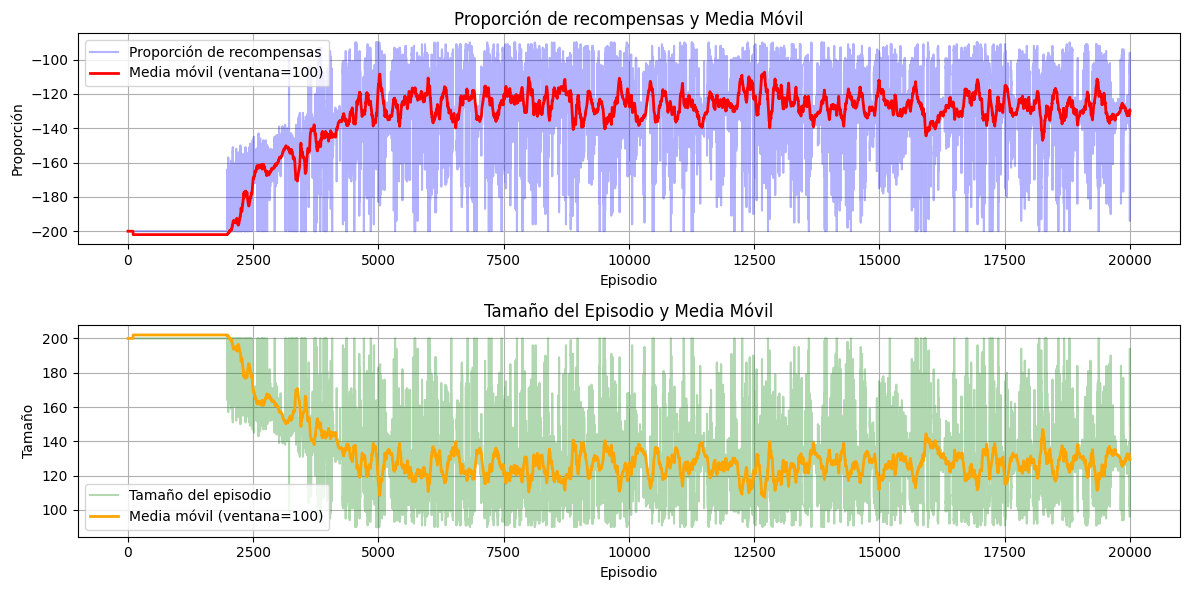

In [ ]:
plot(rewards_per_episode, episodes_sizes)


En la primera gráfica podemos ver como el algoritmo empieza en -200 recompensa, pero conforme van pasando los episodios y empieza a realizar menos exploración y a optimizar su política sus recompensas comienzan a mejorar. Así hasta los 5000 episodios donde a partir de ese punto no hay mejora y las recompensas se mantienen entre -120 y -100.

En la segunda gráfica podemos ver como el algoritmo empieza con un tamaño de episodio de 200, esto nos indica que esos episodios terminan por truncamiento y poco a poco conforme la política mejora se alcanzan mejores soluciones permitiendo que el tamaño del episodio se quede optimizado entre 120 y 100 pasos.

En conclusión el algoritmo parece demostrar una mejoría conforme el número de episodios, hasta llegar a los 5000 episodios donde se mantiene estable. No se aprecia un entrenamiento inestable y se afirmaría que la política del algoritmo parece óptima.

Realizamos un episodio con la politica optima y generamos el video.

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
# Se pasa agent.weights en lugar de agent.Q porque estamos usando Sarsa Semi-Gradiente
pi, actions, frames = pi_star_from_Q(tcenv, agent.weights)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

Política óptima obtenida
 {((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 9), (8, 8), (8, 8), (8, 9), (8, 8), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 8), (8, 8), (8, 8), (8, 9), (7, 8), (7, 8), (7, 9), (7, 8), (7, 8)): 0, ((8, 9), (8, 8), (8, 8), (8, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (8, 8), (8, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (8, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (7, 8), (7, 7), (7, 7), (7, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 7)): 0, ((7, 8), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7)): 0, ((7, 8), (7, 7), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (6, 7)): 0, ((7, 8), (7, 7), (7, 7), (7, 7), (7, 

In [ ]:
create_gif(frames, "SarsaSemiGradiente.mp4", fps=24)  # saves the GIF locally

Moviepy - Building video SarsaSemiGradiente.mp4.
Moviepy - Writing video SarsaSemiGradiente.mp4



Moviepy - Done !
Moviepy - video ready SarsaSemiGradiente.mp4


La solución podría ser mejor, hace algún movimiento innecesario, pero rápidamente se da cuenta de como alcanzar la montaña y completa el problema de manera efectiva. Por lo que el algoritmo alcanza una buena política y es suficientemente bueno para la resolución del ejercicio.

# Q-Learning

Q-Learning es un algoritmo que utiliza una tabla llamada **Q**, donde cada entrada representa un estado y las acciones posibles, asignando un valor que indica la utilidad esperada de tomar esa acción en ese estado. En cada paso, el agente elige una acción según una estrategia de exploración, recibe una recompensa y actualiza el valor Q de la acción elegida basándose en la recompensa obtenida y la mejor acción futura.

Definimos el agente

In [ ]:
class QLearning:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.01):
        """
        Inicializa el agente de Q-Learning con Tile Coding.

        Parámetros:
        - env: Entorno de Gymnasium con codificación de tiles.
        - alpha: Tasa de aprendizaje.
        - gamma: Factor de descuento (importancia de recompensas futuras).
        - epsilon: Probabilidad inicial de exploración (ε-greedy).
        - epsilon_decay: Factor de reducción de epsilon por episodio.
        - min_epsilon: Límite inferior de epsilon para evitar exploración excesiva.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Número de acciones posibles en el entorno
        self.num_actions = env.action_space.n

        # Número total de características en la codificación de tiles
        self.num_features = env.n_tilings * np.prod(env.bins)

        # Inicializa la tabla Q con valores aleatorios pequeños para evitar sesgos iniciales
        self.Q = np.random.uniform(low=-1, high=1, size=(self.num_features, self.num_actions))

    def q_value(self, active_features, a):
        """
        Calcula el valor de Q(s,a) como la suma de los pesos para los índices activos.

        Parámetros:
        - active_features: Lista de índices de características activas para el estado s.
        - a: Acción seleccionada.

        Retorna:
        - Valor de Q(s,a) sumando los valores de las características activas para la acción a.
        """
        return self.Q[active_features, a].sum()

    def compute_q_values(self, active_features, num_actions):
        """
        Calcula Q(s,a) para todas las acciones posibles en el estado actual.

        Parámetros:
        - active_features: Lista de índices de características activas.
        - num_actions: Número total de acciones en el entorno.

        Retorna:
        - Un array 1D con los valores Q(s,a) para cada acción a.
        """
        q_vals = np.zeros(num_actions)
        for a in range(num_actions):
            q_vals[a] = self.q_value(active_features, a)  # Calcula Q(s,a) para cada acción
        return q_vals

    def choose_action(self, active_features):
        """
        Selecciona una acción usando la estrategia ε-greedy.

        Parámetros:
        - active_features: Lista de índices de características activas del estado actual.

        Retorna:
        - Acción seleccionada (exploratoria o explotadora).
        """
        if np.random.rand() < self.epsilon:
            # Exploración: Selecciona una acción aleatoria con probabilidad ε
            action = np.random.choice(self.num_actions)
        else:
            # Explotación: Selecciona la acción con el mayor valor Q estimado
            action = np.argmax(self.compute_q_values(active_features, self.num_actions))
        return action

    def update(self, active_features, active_features_next, a, reward):
        """
        Actualiza los valores de la función Q utilizando la ecuación de Bellman.

        Parámetros:
        - active_features: Lista de índices de características activas en el estado actual.
        - active_features_next: Lista de índices de características activas en el próximo estado.
        - a: Acción tomada en el estado actual.
        - reward: Recompensa recibida después de tomar la acción a.
        """
        # Calcula la actualización de Q usando la regla de actualización de Q-Learning

        for i in active_features:
            self.Q[i, a] += self.alpha * (reward + self.gamma * np.max(self.compute_q_values(active_features_next, self.num_actions)) - self.q_value(active_features, a))


    def decay_epsilon(self):
        """
        Reduce el valor de epsilon para disminuir la exploración con el tiempo.
        Se asegura de que epsilon no caiga por debajo de min_epsilon.
        """
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)


Definimos los hiperparámetros del agente Q-Learning con Tile Coding.

In [ ]:
# Hiperparámetros
num_episodes = 20000  # Número total de episodios de entrenamiento
GAMMA = 0.99  # Factor de descuento: importancia de las recompensas futuras (0 a 1)
ALPHA = 0.01  # Tasa de aprendizaje: cuánto se ajustan los valores Q en cada actualización
EPSILON = 1.0  # Probabilidad de exploración inicial (epsilon-greedy)
EPSILON_DECAY = 0.999  # Factor de decaimiento de epsilon: reduce la exploración con el tiempo
MIN_EPSILON = 0.01  # Valor mínimo de epsilon: asegura una mínima exploración continua

Inicalizamos el agente

In [ ]:
# Inicializar el agente
agent = QLearning(
    env=tcenv,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)


In [ ]:
# --- Bucle principal de entrenamiento con QLearning ---
rewards_per_episode = []  # Lista para almacenar la recompensa total de cada episodio
episodes_sizes = []  # Lista para almacenar el número de pasos de cada episodio

for episode in range(num_episodes):
    # Resetear el entorno al inicio de cada episodio
    obs, info = tcenv.reset(seed=semilla)
    # Obtener las características activas del estado inicial
    active_features = tcenv.last_active_features

    total_reward = 0  # Inicializar la recompensa total del episodio
    episode_steps = 0  # Inicializar el contador de pasos del episodio
    done = False  # Inicializar el indicador de episodio terminado

    # Bucle principal del episodio (hasta que termine o se trunque)
    while not done:
        # Seleccionar una acción usando la política epsilon-greedy
        a = agent.choose_action(active_features)
        # Ejecutar la acción en el entorno y obtener la siguiente observación, recompensa, etc.
        obs_next, reward, done, truncated, info = tcenv.step(a)
        # Obtener las características activas del siguiente estado
        active_features_next = tcenv.last_active_features



        # Actualizar la tabla Q con la experiencia obtenida
        agent.update(active_features, active_features_next, a, reward)

        # Actualizar el estado actual y el contador de pasos
        active_features = active_features_next
        episode_steps += 1
        done  = done or truncated
        total_reward += reward  # Acumular la recompensa del paso

    # Reducir epsilon después de cada episodio para disminuir la exploración
    agent.decay_epsilon()
    # Almacenar la recompensa total y el número de pasos del episodio
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(episode_steps)
    # Imprimir información del episodio
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Calcular la recompensa promedio después del entrenamiento
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")

Se han truncado las últimas 5000 líneas del flujo de salida.
Episode 15002/20000, total reward: -144.0
Episode 15003/20000, total reward: -144.0
Episode 15004/20000, total reward: -140.0
Episode 15005/20000, total reward: -145.0
Episode 15006/20000, total reward: -150.0
Episode 15007/20000, total reward: -146.0
Episode 15008/20000, total reward: -143.0
Episode 15009/20000, total reward: -144.0
Episode 15010/20000, total reward: -150.0
Episode 15011/20000, total reward: -155.0
Episode 15012/20000, total reward: -145.0
Episode 15013/20000, total reward: -143.0
Episode 15014/20000, total reward: -150.0
Episode 15015/20000, total reward: -151.0
Episode 15016/20000, total reward: -152.0
Episode 15017/20000, total reward: -150.0
Episode 15018/20000, total reward: -157.0
Episode 15019/20000, total reward: -147.0
Episode 15020/20000, total reward: -155.0
Episode 15021/20000, total reward: -153.0
Episode 15022/20000, total reward: -152.0
Episode 15023/20000, total reward: -148.0
Episode 15024/2

De primeras parece algo mejor que el algoritmo anterior, el promedio es algo mas alto por lo que parece que alcanza mejores soluciones.

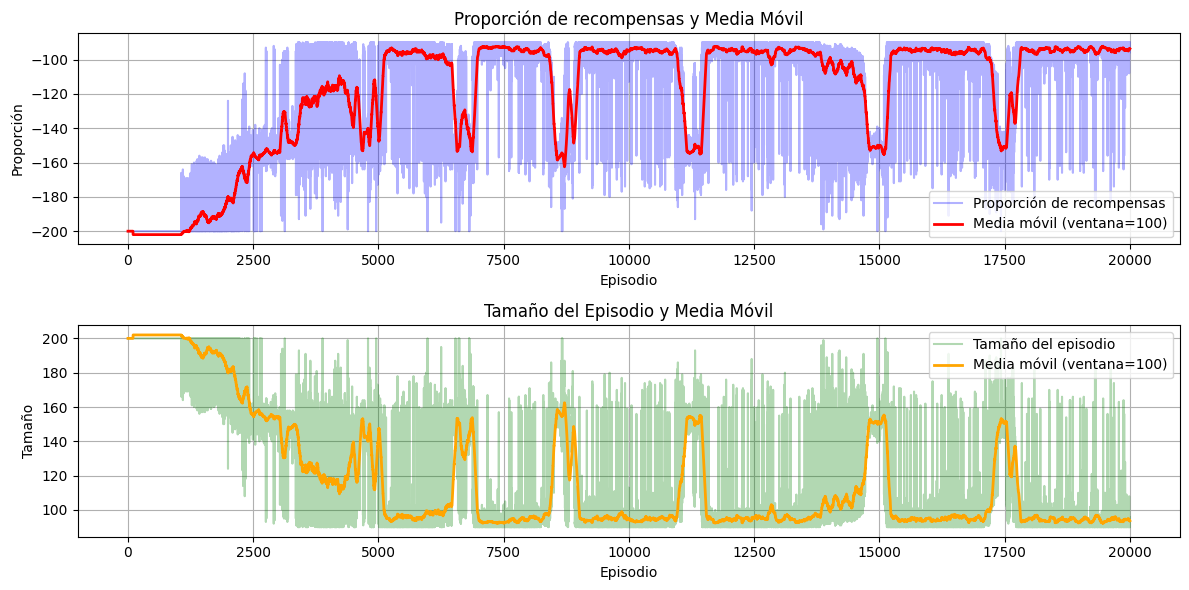

In [ ]:
plot(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)



En la primera gráfica podemos apreciar el cómo el agente empieza con recompensas muy bajas y como rapidamente consigue mejorar sus recompensas. Sin embargo, parece que su entrenamiento no es estable, sufre de bastantes de caídas o subidas. Pero aun con todo consigue una politica optima y mejor que Sarsa Semi Gradiente.

En la segunda gráfica también podemos comprobar dicha inestabilidad con el tamaño de los episodios, que van fluctuando con caídas y subidas y teniendo episodios, aunque a favor decir que jamas se vuelve a terminar por truncamiento.

Ahora analicemos la politica final en forma de video

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
pi, actions, frames = pi_star_from_Q(tcenv, agent.Q)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

Política óptima obtenida
 {((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 9), (8, 8), (8, 8), (8, 9), (8, 8), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 8), (8, 8), (8, 8), (8, 9), (7, 8), (7, 8), (7, 9), (7, 8), (7, 8)): 0, ((8, 9), (8, 8), (8, 8), (8, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (8, 8), (8, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (8, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (7, 8), (7, 7), (7, 7), (7, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 7)): 0, ((7, 8), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7)): 0, ((7, 8), (7, 7), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (6, 7)): 0, ((7, 8), (7, 7), (7, 7), (7, 7), (7, 

In [ ]:
create_gif(frames, "QLearning.mp4", fps=24)  # saves the GIF locally

Moviepy - Building video QLearning.mp4.
Moviepy - Writing video QLearning.mp4



Moviepy - Done !
Moviepy - video ready QLearning.mp4


Se puede apreciar como resuelve el problema, pero realiza movimientos innecesarios. Además a la hora de coger impulso coge demasiado impulso para subir la montaña, cuando no es necesario que coja tanto. En conclusión si lo resuelve, pero la solución admite mejora.

# Deep Q-Learning

Deep Q-Learning es un algoritmo de aprendizaje por refuerzo que utiliza redes neuronales profundas para aproximar la función de valor Q, la cual estima la recompensa esperada para cada par de estado-acción en un entorno dado. El objetivo del algoritmo es aprender una política que maximice la recompensa acumulada a lo largo del tiempo. Utiliza una política epsilon-greedy para equilibrar la exploración y la explotación, donde el agente selecciona una acción aleatoria con una probabilidad epsilon o la acción con el valor Q más alto según la red neuronal. Durante el entrenamiento, los Q-values se actualizan utilizando la ecuación de Bellman, y se emplea una red objetivo separada para calcular los Q-values futuros, lo que ayuda a estabilizar el proceso de aprendizaje al reducir las oscilaciones y las actualizaciones inestables. Deep Q-Learning ha sido muy exitoso en entornos con espacios de acción grandes y complejos, como juegos de video o simulaciones, donde las redes neuronales son capaces de manejar la gran cantidad de datos y patrones involucrados.

Seleccionamos el device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


La red neuronal definida en la clase `NN` es red compuesta por **tres capas lineales**. La entrada pasa primero por una capa densa (`fc1`) con **128 neuronas**, seguida de una segunda capa oculta (`fc2`) con **64 neuronas**, y finalmente llega a la capa de salida (`fc3`) que tiene un número de neuronas igual al tamaño de salida especificado. Cada una de las dos primeras capas usa la función de activación **ReLU** (`torch.relu`), lo que introduce no linealidad en el modelo. La última capa no tiene activación.

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


La clase `Buffer` implementa una memoria de repetición que se utilizara para almacenar experiencias del agente y reutilizarlas en el entrenamiento.


In [ ]:

class Buffer:
    def __init__(self, capacity):
        """
        Inicializa un buffer de experiencia con una capacidad máxima.

        Parámetros:
        - capacity: número máximo de experiencias que puede almacenar el buffer.
        """
        self.buffer = []  # Lista donde se almacenarán las experiencias
        self.capacity = capacity  # Capacidad máxima del buffer
        self.position = 0  # Índice donde se almacenará el siguiente dato

    def push(self, state, action, reward, next_state, done):
        """
        Almacena una nueva experiencia en el buffer.

        Parámetros:
        - state: estado actual del agente.
        - action: acción tomada en ese estado.
        - reward: recompensa obtenida tras la acción.
        - next_state: estado siguiente tras la acción.
        - done: indica si el episodio ha terminado.
        """
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)  # Añade un espacio en la lista si aún hay capacidad
        self.buffer[self.position] = (state, action, reward, next_state, done)  # Guarda la experiencia
        self.position = (self.position + 1) % self.capacity  # Usa reemplazo circular

    def sample(self, batch_size):
        """
        Obtiene una muestra aleatoria de experiencias almacenadas.

        Parámetros:
        - batch_size: número de experiencias a muestrear.

        Retorna:
        - Un conjunto de experiencias descomprimido en listas separadas (estado, acción, recompensa, etc.).
        """
        batch = random.sample(self.buffer, batch_size)  # Selecciona aleatoriamente una muestra del buffer
        return zip(*batch)  # Descompone la muestra en listas separadas

    def __len__(self):
        """
        Retorna la cantidad actual de elementos almacenados en el buffer.
        """
        return len(self.buffer)


Implementación de una red neuronal de Q-learning (DQN) para aprendizaje por refuerzo.

In [ ]:
class DQN:


    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=10000, batch_size=64):
        """
        Inicializa los parámetros y la red neuronal de Q-learning.

        :param env: El entorno de aprendizaje, que debe tener espacio de acciones (action_space.n) y tamaño de los tiles (tile_size, n_tilings).
        :param alpha: Tasa de aprendizaje.
        :param gamma: Factor de descuento para el valor futuro de las recompensas.
        :param epsilon: Probabilidad inicial de seleccionar una acción aleatoria (exploración).
        :param epsilon_decay: Tasa de decaimiento de epsilon con el tiempo (para balancear exploración y explotación).
        :param epsilon_min: Valor mínimo de epsilon.
        :param buffer_size: Tamaño del buffer de memoria (replay buffer) para almacenar transiciones.
        :param batch_size: Tamaño del lote (batch) para el entrenamiento.
        """

        # Guardamos el entorno y los parámetros relevantes
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.buffer_size = buffer_size

        # Inicialización del buffer de memoria
        self.memory = Buffer(self.buffer_size)

        # Número de acciones posibles en el entorno y el número de características
        self.n_actions = env.action_space.n
        self.n_features = env.tile_size * env.n_tilings  # Tamaño de la representación del estado

        # Inicialización de las redes neuronales de la política y la red objetivo
        self.policy_net = NN(self.n_features, self.n_actions).to(device)  # Red de política (Q)
        self.target_net = NN(self.n_features, self.n_actions).to(device)  # Red objetivo (Q objetivo)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Inicializa la red objetivo con los pesos de la política
        self.target_net.eval()  # Pone la red objetivo en modo de evaluación
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=alpha)  # Optimizador Adam para la red de política

    def select_action(self, state):
        """
        Selecciona una acción basada en la política epsilon-greedy.

        :param state: El estado actual (entrada de la red neuronal).
        :return: La acción seleccionada.
        """

        # Exploración vs explotación (epsilon-greedy)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)  # Acción aleatoria (exploración)

        # Crear la representación one-hot del estado
        state_tensor = torch.zeros(1, self.n_features, device=device, dtype=torch.float32)
        state_tensor[0, state] = 1  # Establecer los features activos a 1

        # Seleccionar la acción con el mayor valor Q
        with torch.no_grad():
            return self.policy_net(state_tensor).argmax().item()  # Acción con el valor Q máximo (explotación)

    def optimize(self, state):
        """
        Optimiza la red neuronal de Q-learning usando un lote de experiencias almacenadas en la memoria.

        :param state: El estado actual, usado para obtener las transiciones de la memoria.
        """

        # Obtener un lote de transiciones del buffer de memoria
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, batch)

        # Convertir los estados y acciones a tensores
        states_np = states  # Estados como array de características activas
        next_states_np = next_states  # Estados siguientes como array de características activas

        actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)

        # Crear tensores one-hot para los estados y los estados siguientes
        states = torch.zeros(self.batch_size, self.n_features, device=device, dtype=torch.float32)
        for i, s in enumerate(states_np):
            states[i, s] = 1  # Establecer los features activos a 1

        next_states = torch.zeros(self.batch_size, self.n_features, device=device, dtype=torch.float32)
        for i, ns in enumerate(next_states_np):
            next_states[i, ns] = 1  # Establecer los features activos a 1

        # Calcular los valores Q actuales y esperados
        q_values = self.policy_net(states).gather(1, actions).squeeze()  # Valores Q actuales (policy network)
        next_q_values = self.target_net(next_states).max(1)[0]  # Valores Q siguientes (target network)
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)  # Valor Q esperado (TD target)

        # Calcular la pérdida usando la diferencia cuadrada media
        loss = nn.MSELoss()(q_values, expected_q_values.detach())

        # Realizar el paso de optimización
        self.optimizer.zero_grad()  # Poner los gradientes a cero
        loss.backward()  # Propagación hacia atrás para calcular los gradientes
        self.optimizer.step()  # Actualizar los pesos de la red de política

    def decay_epsilon(self):
        """
        Disminuye el valor de epsilon para reducir la exploración con el tiempo y favorecer más explotación.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)  # Decaimiento exponencial de epsilon


Definimos los hiperparámetros del algoritmo

In [ ]:
gamma = 0.99  # Factor de descuento
alpha = 0.001  # Tasa de aprendizaje
epsilon = 1.0  # Probabilidad inicial de exploración
epsilon_min = 0.01  # Probabilidad mínima de exploración
epsilon_decay = 0.995  # Decaimiento de epsilon
buffer_size = 10000  # Tamaño del buffer de memoria
batch_size = 64  # Tamaño del minibatch
num_episodes = 20000  # Número total de episodios

Inicializamos el agente

In [ ]:
agent = DQN(tcenv, alpha, gamma, epsilon, epsilon_decay, epsilon_min, buffer_size, batch_size)

In [ ]:
# --- Bucle principal de entrenamiento con DeepQLearning ---
rewards_per_episode = []  # Lista para almacenar la recompensa total de cada episodio
episodes_sizes = []  # Lista para almacenar el número de pasos de cada episodio

# Empezamos el entrenamiento para un número determinado de episodios
for episode in range(num_episodes):
    # Reiniciamos el entorno y obtenemos el estado inicial
    state, _ = tcenv.reset(seed=semilla)  # Reiniciar el entorno con una semilla aleatoria
    state = tcenv.last_active_features  # Obtener las *active features* del estado inicial
    total_reward = 0  # Recompensa total acumulada en el episodio
    episode_steps = 0  # Número de pasos tomados en el episodio

    # Empezamos el bucle de pasos dentro del episodio
    while True:
        # Seleccionamos una acción usando la política actual
        action = agent.select_action(state)

        # Ejecutamos la acción seleccionada en el entorno y obtenemos la transición
        next_state, reward, terminated, truncated, _ = tcenv.step(action)
        next_state = tcenv.last_active_features  # Obtener las *active features* del siguiente estado

        # Comprobamos si el episodio ha terminado o se ha truncado
        done = terminated or truncated

        # Almacenamos la transición (estado, acción, recompensa, siguiente estado, fin del episodio) en la memoria del agente
        agent.memory.push(state, action, reward, next_state, done)

        # Actualizamos el estado al siguiente estado
        state = next_state
        total_reward += reward  # Acumulamos la recompensa
        episode_steps += 1  # Incrementamos el contador de pasos

        # Si el episodio ha terminado, salimos del bucle
        if done:
            break

        # Si la memoria del agente tiene suficientes muestras, realizamos una optimización
        if len(agent.memory) > agent.batch_size:
            # Entrenar DQN con una muestra aleatoria del buffer de memoria
            agent.optimize(state)

    # Reducimos epsilon para que el agente explore menos y explote más con el tiempo
    agent.decay_epsilon()

    # Almacenamos la recompensa total y el número de pasos del episodio
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(episode_steps)

    # Actualizamos la red objetivo cada 10 episodios
    if episode % 10 == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())

    # Imprimimos el progreso del entrenamiento para el episodio actual
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Al final del entrenamiento, calculamos la recompensa promedio
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")


Se han truncado las últimas 5000 líneas del flujo de salida.
Episode 15002/20000, total reward: -178.0
Episode 15003/20000, total reward: -113.0
Episode 15004/20000, total reward: -94.0
Episode 15005/20000, total reward: -185.0
Episode 15006/20000, total reward: -94.0
Episode 15007/20000, total reward: -108.0
Episode 15008/20000, total reward: -90.0
Episode 15009/20000, total reward: -93.0
Episode 15010/20000, total reward: -98.0
Episode 15011/20000, total reward: -170.0
Episode 15012/20000, total reward: -103.0
Episode 15013/20000, total reward: -111.0
Episode 15014/20000, total reward: -121.0
Episode 15015/20000, total reward: -102.0
Episode 15016/20000, total reward: -171.0
Episode 15017/20000, total reward: -104.0
Episode 15018/20000, total reward: -182.0
Episode 15019/20000, total reward: -117.0
Episode 15020/20000, total reward: -91.0
Episode 15021/20000, total reward: -161.0
Episode 15022/20000, total reward: -200.0
Episode 15023/20000, total reward: -93.0
Episode 15024/20000, t

La media de este algoritmo parece que es algo mejor que Q learning aunque peor que Sarsa Semi Gradiente.

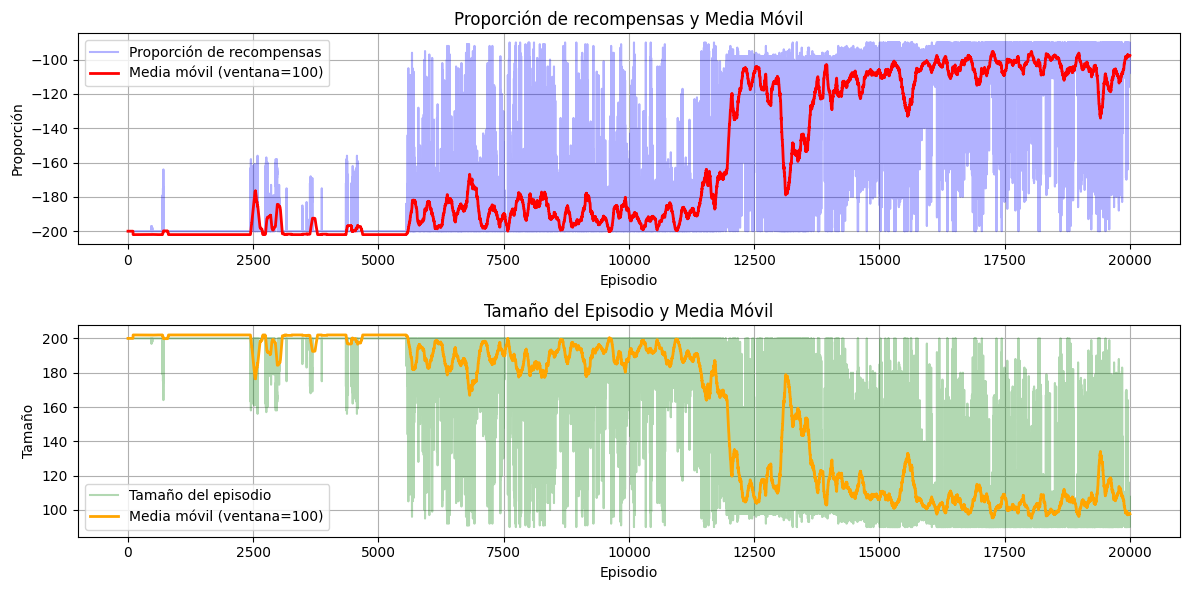

In [ ]:
plot(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)

En la primera grafica lo que podemos destacar es que a Deep Q learning le lleva un mayor número de episodios el obtener recompensas mejores, inclusive cuando empieza a mejorar mejora poco y en el episodio 12500 ya alcanza recompensas más óptimas, aunque se aprecia algo de inestabilidad con algunas caídas.

En la segunda gráfica se puede apreciar el cómo también tarda en reducir el tamaño de los episodios, ya que hasta los 5000 episodios termina por truncamiento, luego mejoran un poco y posteriormente se alcanzan tamaños optimos. En general esta opción aparenta ser que las dos anteriores.

Este metodo simula un episodio  utilizando la política aprendida por un agente basado en redes neuronales. Inicializa el entorno, pone la red en modo evaluación y, en cada paso, convierte la observación en un tensor, predice la mejor acción con la red neuronal, guarda la relación estado-acción en un diccionario (`pi_star`), y avanza en el entorno hasta que el episodio termine. Además, registra el historial de acciones (`actions_history`) y captura imágenes (`frames`) para visualizar la trayectoria del agente. Finalmente, devuelve estos datos para analizar el comportamiento del agente.

In [ ]:
def pi_star_from_Deep(env, agent):
    frames = []
    done = False
    pi_star = {}

    obs, info = env.reset(seed=semilla)
    active_features = env.last_active_features  # Obtener las active features iniciales
    img = env.render()
    frames.append(img)

    actions = ""
    agent.policy_net.eval()

    while not done:
        # Crear tensor de estado con las active features
        state_tensor = torch.zeros(1, agent.n_features, device=device, dtype=torch.float32)
        state_tensor[0, active_features] = 1  # Establecer las active features en 1

        with torch.no_grad():
            action = agent.policy_net(state_tensor).argmax().item()

        # Convert obs to a tuple if it's not already
        obs_tuple = tuple(obs) if isinstance(obs, (list, np.ndarray)) else obs
        pi_star[obs_tuple] = action
        actions += f"{action}, "

        obs, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)

        done = terminated or truncated
        active_features = env.last_active_features  # Actualizar active features

    return pi_star, actions, frames

Usando el metodo generamos un video con la politica optima.

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Deep
pi, actions, frames = pi_star_from_Deep(tcenv, agent)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

Política óptima obtenida
 {((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 9), (8, 8), (8, 8), (8, 9), (8, 8), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 8), (8, 8), (8, 8), (8, 9), (7, 8), (7, 8), (7, 9), (7, 8), (7, 8)): 0, ((8, 9), (8, 8), (8, 8), (8, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (8, 8), (8, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (8, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (7, 8), (7, 7), (7, 7), (7, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 7)): 0, ((7, 8), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7)): 0, ((7, 8), (7, 7), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (6, 7)): 0, ((7, 8), (7, 7), (7, 7), (7, 7), (7, 

In [ ]:
create_gif(frames, "DeepQLearning.mp4", fps=24)  # saves the GIF locally

Moviepy - Building video DeepQLearning.mp4.
Moviepy - Writing video DeepQLearning.mp4



Moviepy - Done !
Moviepy - video ready DeepQLearning.mp4


Dado que en los últimos 5000 episodios se mantiene bastante estable y con excelentes recompensas parece que eso consigue que la política final se optimice bastante de cara al tener una política final. Dando así que la resolución de este ejercicio es la mejor haciendo los movimientos necesarios y con el impulso suficiente. Por lo que a nivel de entrenamiento su promedio es peor y más inestable durante una buena parte respecto a Sarsa Semi Gradiente; sin embargo, gracias a los episodios finales en los que se mantiene estable y óptimo es suficiente para que la red neuronal optimice la política.

# Monte Carlo (On Policy)

Monte Carlo on-policy es un algoritmo en donde el agente aprende una política directamente a partir de las experiencias obtenidas al interactuar con el entorno, sin necesidad de un modelo del mismo. En lugar de usar un valor Q  predefinido, el agente estima las recompensas futuras esperadas a través de simulaciones de episodios completos. En cada episodio, el agente sigue una política y al final del episodio, calcula la recompensa acumulada desde cada estado visitado. Luego, actualiza las estimaciones de valor de esos estados basándose en la media de las recompensas obtenidas en episodios previos. Este proceso se repite durante varios episodios, y el algoritmo ajusta su política para maximizar las recompensas acumuladas.

Definimos los hiperparametros

In [ ]:
num_episodes = 20000

Definimos el agente

In [ ]:
class MonteCarloOnPolicyAgent:
    def __init__(self, env, gamma=0.999, epsilon=1.0, epsilon_min = 0.01, epsilon_decay = 0.999):
        """
        Inicializa el agente Monte Carlo on-policy.

        Parámetros:
        - env: El entorno en el que el agente interactúa.
        - gamma: Factor de descuento para las recompensas futuras.
        - epsilon: Probabilidad de exploración (estrategia ε-greedy).
        - epsilon_min: Valor mínimo de epsilon (para evitar exploración 0).
        - epsilon_decay: Tasa de decaimiento de epsilon con el tiempo.
        """
        self.env = env
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Probabilidad inicial de exploración
        self.epsilon_min = epsilon_min  # Valor mínimo para epsilon
        self.epsilon_decay = epsilon_decay  # Decaimiento de epsilon

        self.num_actions = env.action_space.n  # Número de acciones posibles en el entorno
        self.num_features =  env.tile_size * env.n_tilings  # Número de características activas del estado
        self.Q = np.zeros([self.num_features, self.num_actions])  # Tabla Q inicializada a ceros
        self.returns = {}  # Diccionario para almacenar los retornos observados

    def q_value(self, active_features, a):
        """
        Calcula el valor Q(s,a) como la suma de los pesos para los índices activos.

        Parámetros:
        - active_features: Lista de índices de características activas para el estado s.
        - a: Acción seleccionada.

        Retorna:
        - Valor de Q(s,a) sumando los valores de las características activas para la acción a.
        """
        return self.Q[active_features, a].sum()  # Suma de las características activas para la acción a

    def decay_epsilon(self):
        """
        Decae el valor de epsilon de acuerdo a la tasa de decaimiento para promover más explotación con el tiempo.
        """
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)  # Reducir epsilon y asegurarse de que no sea menor que epsilon_min

    def choose_action(self, active_features):
        """
        Selecciona una acción usando la estrategia ε-greedy.

        Parámetros:
        - active_features: Lista de índices de características activas del estado actual.

        Retorna:
        - Acción seleccionada (exploratoria o explotadora).
        """
        if np.random.rand() < self.epsilon:
            # Exploración: Selecciona una acción aleatoria con probabilidad ε
            action = np.random.choice(self.num_actions)
        else:
            # Explotación: Selecciona la acción con el mayor valor Q estimado
            q_values = [np.sum(self.Q[active_features, action]) for action in range(self.num_actions)]
            action = np.argmax(q_values)  # Acción con el valor Q más alto
        return action

    def update(self, episode):
        """
        Actualiza la tabla Q y los retornos utilizando los episodios completados.

        Parámetros:
        - episode: Una lista de transiciones (estado, acción, recompensa) obtenidas durante el episodio.
        """
        states, actions, rewards = zip(*episode)  # Desempaquetar los estados, acciones y recompensas del episodio
        G = 0  # Inicializar el retorno total

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]  # Obtener el estado, acción y recompensa en el paso t
            G = self.gamma * G + reward  # Calcular el retorno descontado

            # Convertir el estado (lista) a una tupla para hacerla "hashable"
            state_tuple = tuple(state)

            # Si el par (estado, acción) no ha sido visitado en este episodio
            if (state_tuple, action) not in [((tuple(x[0])), x[1]) for x in episode[:t]]:
                if (state_tuple, action) not in self.returns:
                    self.returns[(state_tuple, action)] = []  # Inicializar la lista de retornos para el par (estado, acción)
                self.returns[(state_tuple, action)].append(G)  # Almacenar el retorno en la lista correspondiente

                # Actualizar el valor Q con el valor promedio de los retornos observados
                for i in state:
                  self.Q[i, action] = np.mean(self.returns[(state_tuple, action)])

        # Reducir epsilon para aumentar la explotación en lugar de la exploración
        self.decay_epsilon()


Inicializamos el agente con los valores por defecto

In [ ]:
agent = MonteCarloOnPolicyAgent(tcenv)

In [ ]:
# --- Bucle principal de entrenamiento con Monte Carlo On-Policy ---
rewards_per_episode = []  # Lista para almacenar la recompensa total de cada episodio
episodes_sizes = []  # Lista para almacenar el número de pasos de cada episodio

for episode in range(num_episodes):
    # Resetear el entorno al inicio de cada episodio
    obs, info = tcenv.reset(seed=semilla)
    # Obtener las características activas del estado inicial
    active_features = tcenv.last_active_features
    trajectory = []  # Lista para almacenar la trayectoria del agente (estado, acción, recompensa)
    total_reward = 0  # Inicializar la recompensa total del episodio
    episode_steps = 0  # Inicializar el contador de pasos del episodio
    done = False  # Inicializar el indicador de episodio terminado
    # Bucle principal del episodio (hasta que termine o se trunque)
    while not done:
        # Seleccionar una acción usando la política epsilon-greedy
        a = agent.choose_action(active_features)
        # Ejecutar la acción en el entorno y obtener la siguiente observación, recompensa, etc.
        obs_next, reward, done, truncated, info = tcenv.step(a)
        # Obtener las características activas del siguiente estado
        trajectory.append((active_features, a, reward))  # Guardar la transición (estado, acción, recompensa)
        active_features_next = tcenv.last_active_features

        # Actualizar el estado actual y el contador de pasos
        active_features = active_features_next
        episode_steps += 1
        done = done or truncated  # El episodio termina si es marcado como terminado o truncado

        total_reward += reward  # Acumular la recompensa del paso

    # Actualizar el agente usando el episodio completo (trajectoria)
    agent.update(trajectory)
    # Almacenar la recompensa total y el número de pasos del episodio
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(episode_steps)

    # Imprimir información del episodio
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Calcular la recompensa promedio después del entrenamiento
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")


Se han truncado las últimas 5000 líneas del flujo de salida.
Episode 15002/20000, total reward: -200.0
Episode 15003/20000, total reward: -200.0
Episode 15004/20000, total reward: -200.0
Episode 15005/20000, total reward: -200.0
Episode 15006/20000, total reward: -200.0
Episode 15007/20000, total reward: -200.0
Episode 15008/20000, total reward: -200.0
Episode 15009/20000, total reward: -200.0
Episode 15010/20000, total reward: -200.0
Episode 15011/20000, total reward: -200.0
Episode 15012/20000, total reward: -200.0
Episode 15013/20000, total reward: -200.0
Episode 15014/20000, total reward: -200.0
Episode 15015/20000, total reward: -200.0
Episode 15016/20000, total reward: -200.0
Episode 15017/20000, total reward: -200.0
Episode 15018/20000, total reward: -200.0
Episode 15019/20000, total reward: -200.0
Episode 15020/20000, total reward: -200.0
Episode 15021/20000, total reward: -200.0
Episode 15022/20000, total reward: -200.0
Episode 15023/20000, total reward: -200.0
Episode 15024/2

Con este promedio de recompensa se nos está dando a entender que el algoritmo no aprende ni optimiza nada. Como podemos ver su media es -200 lo que también nos indica que seguramente nunca complete el problema y episodio termine por truncamiento.

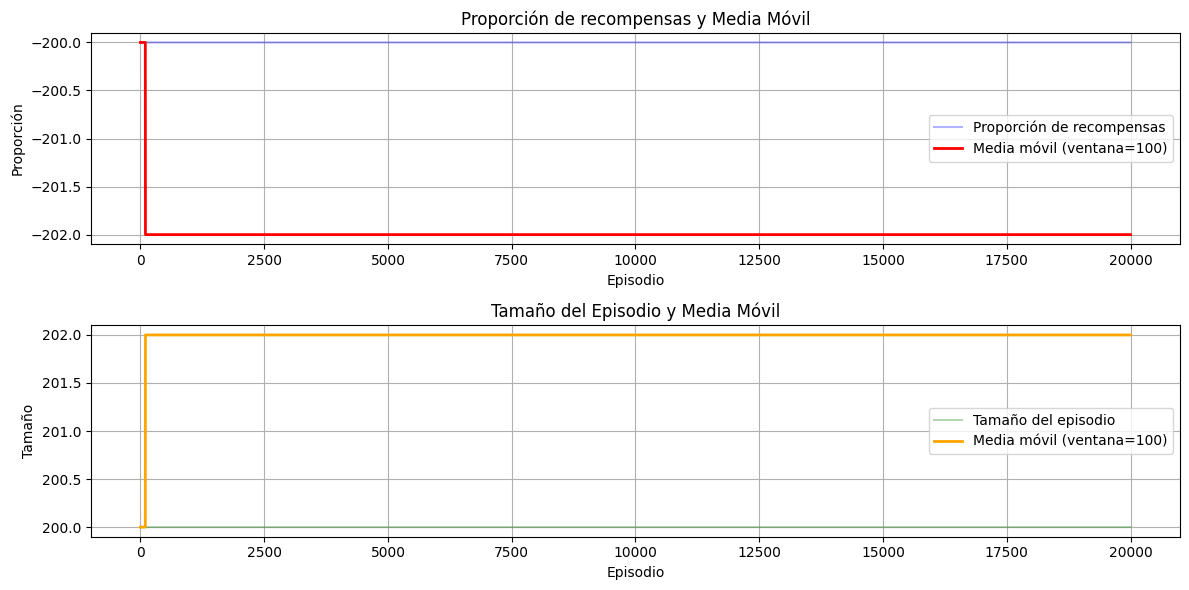

In [ ]:
plot(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)


No hay mucho que comentar en ninguna de la dos gráficas, ni las recompensas varían ni los episodios. Se mantiene en episodios de 200 pasos lo que nos indica que siempre termina por truncamiento y además las recompensas se mantienen constantes en -200.



Veamos la politica final

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
pi, actions, frames = pi_star_from_Q(tcenv, agent.Q)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

Política óptima obtenida
 {((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)): 2, ((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 10), (7, 9), (7, 9)): 2, ((8, 10), (8, 9), (8, 9), (8, 9), (8, 10), (8, 9), (8, 9), (7, 10), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)): 2, ((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9)): 2, ((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 10), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9)): 2} 
 Acciones 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0

In [ ]:
create_gif(frames, "MonteCarloOnPolicy.mp4", fps=24)  # saves the GIF locally

Moviepy - Building video MonteCarloOnPolicy.mp4.
Moviepy - Writing video MonteCarloOnPolicy.mp4



Moviepy - Done !
Moviepy - video ready MonteCarloOnPolicy.mp4


No completa el problema, es mas no hace nada.

# Monte Carlo (Off policy)

El algoritmo Monte Carlo Off-Policy es un enfoque de aprendizaje por refuerzo en el que el agente aprende una política de acción mediante la simulación de episodios, pero la política utilizada para generar las acciones es diferente a la política que está siendo aprendida. En este método, se utilizan las experiencias obtenidas de una política exploratoria  para actualizar los valores de una política objetivo. A lo largo de múltiples episodios, el agente calcula los retornos observados y utiliza estos valores para actualizar las estimaciones de la política objetivo sin seguirla directamente durante la ejecución.

Definimos el agente

In [ ]:
class MonteCarloOffPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        """
        Inicializa el agente Monte Carlo Off-Policy.

        Parámetros:
        - env: El entorno en el que el agente interactúa.
        - gamma: Factor de descuento para las recompensas futuras.
        - epsilon: Tasa de exploración inicial (probabilidad de seleccionar acciones aleatorias).
        - epsilon_decay: Tasa de decaimiento de epsilon (para reducir la exploración con el tiempo).
        - min_epsilon: Valor mínimo de epsilon para evitar exploración nula.
        """
        self.env = env
        self.gamma = gamma  # Factor de descuento para las recompensas futuras
        self.epsilon = epsilon  # Probabilidad inicial de exploración (ε-greedy)
        self.epsilon_decay = epsilon_decay  # Tasa de decaimiento de epsilon
        self.min_epsilon = min_epsilon  # Valor mínimo para epsilon (exploración mínima)

        self.num_actions = env.action_space.n  # Número de acciones posibles en el entorno

        self.num_features = env.n_tilings * np.prod(env.bins)  # Número de características del estado

        # Inicialización de las tablas Q y C
        self.Q = np.zeros([self.num_features, self.num_actions])  # Tabla Q con valores inicializados a 0
        self.C = np.zeros([self.num_features, self.num_actions])  # Tabla C con valores de conteo de visitas

    def q_value(self, active_features, a):
        """
        Calcula el valor Q(s,a) como la suma de los pesos de las características activas para la acción a.

        Parámetros:
        - active_features: Lista de índices de características activas para el estado s.
        - a: Acción seleccionada.

        Retorna:
        - Valor Q(s,a) sumando los valores de las características activas para la acción a.
        """
        return self.Q[active_features, a].sum()  # Calcula la suma de los valores de Q para la acción 'a'

    def compute_q_values(self, active_features, num_actions):
        """
        Calcula los valores Q(s,a) para todas las acciones posibles en el estado actual.

        Parámetros:
        - active_features: Lista de índices de características activas.
        - num_actions: Número total de acciones en el entorno.

        Retorna:
        - Un array 1D con los valores Q(s,a) para cada acción.
        """
        q_vals = np.zeros(num_actions)  # Array para almacenar los valores Q
        for a in range(num_actions):  # Itera sobre todas las acciones posibles
            q_vals[a] = self.q_value(active_features, a)  # Calcula Q(s,a) para cada acción
        return q_vals

    def choose_action(self, active_features):
        """
        Selecciona una acción utilizando la estrategia ε-greedy.

        Parámetros:
        - active_features: Lista de índices de características activas del estado actual.

        Retorna:
        - Acción seleccionada (exploratoria o explotadora).
        """
        if np.random.rand() < self.epsilon:
            # Exploración: Selecciona una acción aleatoria con probabilidad ε
            action = np.random.choice(self.num_actions)
        else:
            # Explotación: Selecciona la acción con el mayor valor Q estimado
            q_values = [np.sum(self.Q[active_features, action]) for action in range(self.num_actions)]
            action = np.argmax(q_values)  # Selecciona la acción con el mayor valor Q
        return action

    def update(self, episode):
        """
        Actualiza la tabla Q utilizando el algoritmo Monte Carlo Off-Policy.

        Parámetros:
        - episode: Una lista de transiciones (estado, acción, recompensa) obtenidas durante el episodio.
        """
        G = 0  # Inicializar el retorno total
        W = 1  # Inicializar el peso de Importance Sampling

        # Recorrer el episodio en reversa (de atrás hacia adelante)
        for t in range(len(episode) - 1, -1, -1):
            active_features, action, reward = episode[t]  # Obtener el estado, acción y recompensa en el paso t
            G = self.gamma * G + reward  # Calcular el retorno descontado

            # Actualizar el conteo C y la tabla Q
            for i in active_features:
                self.C[i, action] += W  # Aumentar el conteo de la acción seleccionada
                self.Q[i, action] += (W / self.C[i, action]) * (G - self.q_value(active_features, action))  # Actualizar Q

            # Si la acción no es la óptima según la política objetivo, terminar el episodio
            if action != np.argmax(self.compute_q_values(active_features, self.num_actions)):
                break

            # Actualizar el peso de Importance Sampling
            W = W * 1.0 / (self.epsilon / self.env.action_space.n + (1 - self.epsilon) * (action == np.argmax(self.compute_q_values(active_features, self.num_actions))))

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)  # Reducir epsilon para favorecer la explotación


Generamos los hiperparametros

In [ ]:
num_episodes = 20000
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Probabilidad de exploración
epsilon_decay = 0.999
epsilon_min = 0.001

Inicializamos el agente

In [ ]:
agent = MonteCarloOffPolicyAgent(tcenv, gamma, epsilon, epsilon_decay, epsilon_min)

In [ ]:
# --- Bucle principal de entrenamiento con QLearning ---
rewards_per_episode = []  # Lista para almacenar la recompensa total de cada episodio
episodes_sizes = []  # Lista para almacenar el número de pasos de cada episodio

for episode in range(num_episodes):
    # Resetear el entorno al inicio de cada episodio
    obs, info = tcenv.reset(seed=semilla)
    # Obtener las características activas del estado inicial
    active_features = tcenv.last_active_features
    trajectory = []  # Lista para almacenar la trayectoria del agente
    total_reward = 0  # Inicializar la recompensa total del episodio
    episode_steps = 0  # Inicializar el contador de pasos del episodio
    done = False  # Inicializar el indicador de episodio terminado
    # Bucle principal del episodio (hasta que termine o se trunque)
    while not done:
        # Seleccionar una acción usando la política epsilon-greedy
        a = agent.choose_action(active_features)
        # Ejecutar la acción en el entorno y obtener la siguiente observación, recompensa, etc.
        obs_next, reward, done, truncated, info = tcenv.step(a)
        # Obtener las características activas del siguiente estado
        trajectory.append((active_features, a,  reward))
        active_features_next = tcenv.last_active_features

        # Actualizar el estado actual y el contador de pasos
        active_features = active_features_next
        episode_steps += 1
        done = done or truncated

        total_reward += reward  # Acumular la recompensa del paso

    agent.update(trajectory)
    # Almacenar la recompensa total y el número de pasos del episodio
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(episode_steps)
    # Imprimir información del episodio
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Calcular la recompensa promedio después del entrenamiento
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")

Se han truncado las últimas 5000 líneas del flujo de salida.
Episode 15002/20000, total reward: -200.0
Episode 15003/20000, total reward: -200.0
Episode 15004/20000, total reward: -200.0
Episode 15005/20000, total reward: -200.0
Episode 15006/20000, total reward: -200.0
Episode 15007/20000, total reward: -200.0
Episode 15008/20000, total reward: -200.0
Episode 15009/20000, total reward: -200.0
Episode 15010/20000, total reward: -200.0
Episode 15011/20000, total reward: -200.0
Episode 15012/20000, total reward: -200.0
Episode 15013/20000, total reward: -200.0
Episode 15014/20000, total reward: -200.0
Episode 15015/20000, total reward: -200.0
Episode 15016/20000, total reward: -200.0
Episode 15017/20000, total reward: -200.0
Episode 15018/20000, total reward: -200.0
Episode 15019/20000, total reward: -200.0
Episode 15020/20000, total reward: -200.0
Episode 15021/20000, total reward: -200.0
Episode 15022/20000, total reward: -200.0
Episode 15023/20000, total reward: -200.0
Episode 15024/2

Resultados iguales de pésimos que con la version on policy.

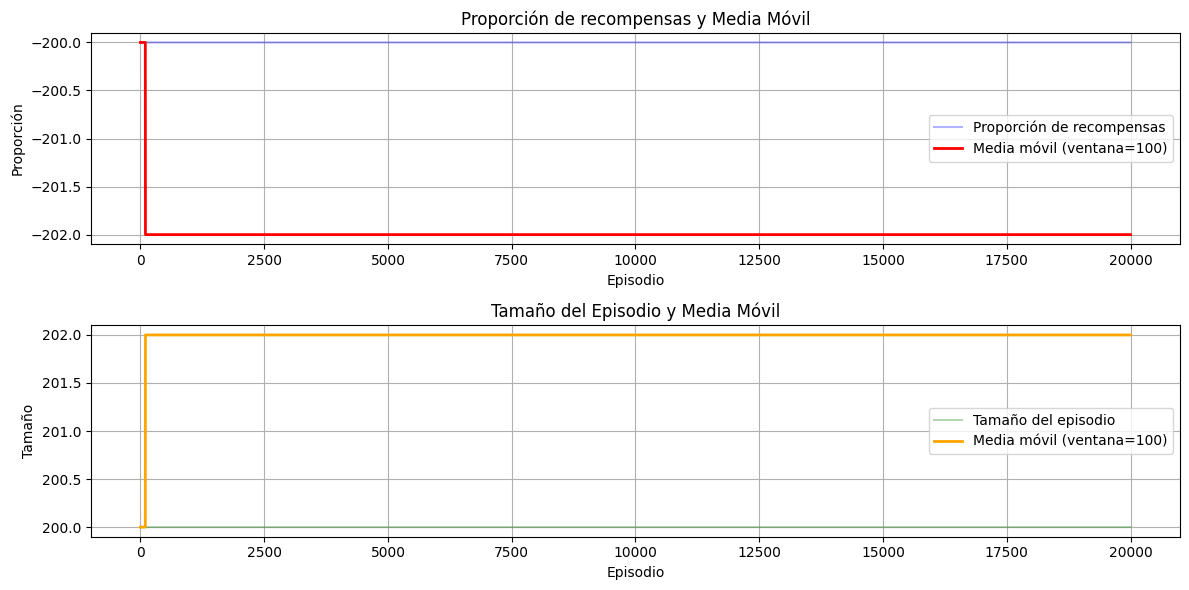

In [ ]:
plot(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)


Resultados iguales de pésimos que con la version on policy. En la documentación ahondaremos más el porqué los algoritmos resuelven o no el problema y porque algunos mejor que otros. De momento añadir que monte Carlo no es una solución posible para este problema.

Veamos que tal la politica final

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
pi, actions, frames = pi_star_from_Q(tcenv, agent.Q)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

Política óptima obtenida
 {((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)): 1, ((8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)): 1, ((8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 1, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 2, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 2, ((8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 1, ((8, 9), (8, 9), (8, 9), (8, 8), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 2, ((8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 1, ((8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (7, 8), (7, 9), (7, 9), (7, 8), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 8), (7, 8), (7, 9), (7, 9), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 9), (7, 8), (7, 8), (7, 

In [ ]:
create_gif(frames, "MonteCarloOffPolicy.mp4", fps=24)  # saves the GIF locally

Moviepy - Building video MonteCarloOffPolicy.mp4.
Moviepy - Writing video MonteCarloOffPolicy.mp4



Moviepy - Done !
Moviepy - video ready MonteCarloOffPolicy.mp4


Aprende algo más, es más la idea en general la tiene, pero no sabe como llevarla a cabo. Por lo que la política no es óptima y el algoritmo no lo resuelve.

# Sarsa

El algoritmo SARSA (State-Action-Reward-State-Action) es un método de aprendizaje por refuerzo que permite al agente aprender a tomar decisiones optimizando una función de valor que estima la recompensa esperada al realizar una acción en un estado determinado. El agente elige una acción utilizando una política de exploración-explotación, recibe una recompensa, y observa el siguiente estado. Luego, el agente selecciona una nueva acción en ese estado y actualiza su estimación de la recompensa esperada, teniendo en cuenta la recompensa recibida y el valor de la acción elegida en el siguiente estado. Este proceso se repite durante varias iteraciones, permitiendo que el agente aprenda gradualmente una política que maximiza las recompensas a lo largo del tiempo.

Definimos el Sarsa Agente

In [ ]:
class SarsaAgent:
    def __init__(self, env, eps=1.0, eps_min = 0.01, decay = 0.999, gamma=0.99, alpha=0.01):
        """Inicializa el agente.

        Parámetros
        ======
        - env: Entorno de Gymnasium
        - eps: tasa de exploración
        - gamma: factor de descuento
        - alpha: tasa de aprendizaje
        """
        self.env = env
        self.eps = eps
        self.eps_min = eps_min
        self.decay = decay
        self.gamma = gamma
        self.alpha = alpha

        # Número de acciones disponibles en el entorno
        self.num_actions = env.action_space.n
        # Número de características activas del estado
        self.num_features = env.n_tilings * np.prod(env.bins)

        # Inicializa la tabla Q basada en el espacio de acciones, no en el espacio de observaciones
        self.Q = np.zeros((self.num_features, self.num_actions))

    def get_q(self, active_features, action):
        """
        Calcula el valor de Q(s, a) como la suma de los pesos de las características activas.

        Parámetros:
        - active_features: Lista de índices de características activas en el estado s.
        - action: Acción para la cual se calcula Q(s, a).

        Retorna:
        - Valor de Q(s, a) sumando los pesos correspondientes a las características activas.
        """
        return np.sum(self.Q[active_features, action])

    def choose_action(self, active_features):
        """
        Selecciona una acción usando la estrategia ε-greedy.

        Parámetros:
        - active_features: Lista de índices de características activas en el estado actual.

        Retorna:
        - Acción seleccionada (exploratoria o explotadora).
        """
        if np.random.rand() < self.eps:
            # Exploración: Selecciona una acción aleatoria con probabilidad ε
            return np.random.choice(self.num_actions)
        else:
            # Explotación: Selecciona la acción con el mayor valor Q estimado
            q_values = [np.sum(self.Q[active_features, action]) for action in range(self.num_actions)]
            return np.argmax(q_values)

    def decay_epsilon(self):
        """
        Disminuye el valor de epsilon con el tiempo para reducir la exploración.

        La tasa de decaimiento hace que el agente se enfoque más en la explotación que en la exploración.
        """
        self.eps = max(self.eps * self.decay, self.eps_min)

    def update(self, active_features, action, reward, active_features_next, done):
        """Actualiza el conocimiento del agente utilizando el último tuple muestreado.

        Parámetros
        ======
        - active_features: características activas del estado actual
        - action: acción tomada en el estado actual
        - reward: recompensa obtenida después de realizar la acción
        - active_features_next: características activas del siguiente estado
        - done: booleano que indica si el episodio ha terminado (True o False)
        """
        # Valor actual de Q para el estado y acción actuales
        current = self.get_q(active_features, action)

        # Valor máximo de Q en el siguiente estado
        if done:
            Qsa_next = 0  # Si el estado es terminal, no tiene valor futuro
        else:
            # Seleccionamos la acción en el siguiente estado
            next_action = self.choose_action(active_features_next)
            # Calculamos el valor Q para el siguiente estado y acción seleccionada
            Qsa_next = self.get_q(active_features_next, next_action)

        # Fórmula de actualización SARSA
        target = reward + (self.gamma * Qsa_next)

        # Actualización de la tabla Q
        for i in active_features:
            self.Q[i, action] += self.alpha * (target - current)


Definimos el agente y el bucle de entrenamiento

In [ ]:
# Crear una instancia del agente SARSA
agent = SarsaAgent(tcenv)

# Listas para guardar las métricas durante el entrenamiento
rewards_per_episode = []  # Recompensas por episodio
episodes_sizes = []  # Número de pasos por episodio

# Definir el número total de episodios para entrenar al agente
num_episodes = 20000

# Bucle principal de entrenamiento
for episode in range(num_episodes):
    # Reiniciar el entorno al comienzo de cada episodio
    obs, info = tcenv.reset(seed = semilla)
    active_features = tcenv.last_active_features  # Obtener las características activas iniciales
    done = False  # Variable que indica si el episodio ha terminado
    episode_reward = 0  # Recompensa acumulada en este episodio
    episode_steps = 0  # Contador de pasos en el episodio

    # Bucle que ejecuta el agente mientras no termine el episodio
    while not done:
        # Elegir una acción basada en las características activas del estado actual
        action = agent.choose_action(active_features)  # Selección de acción mediante epsilon-greedy

        # Tomar la acción y recibir el siguiente estado, recompensa y si el episodio terminó
        next_obs, reward, terminated, truncated, info = tcenv.step(action)
        active_features_next = tcenv.last_active_features  # Obtener las características activas del siguiente estado

        # Actualizar el agente utilizando la experiencia (estado, acción, recompensa, siguiente estado, fin del episodio)
        agent.update(active_features, action, reward, active_features_next, terminated)  # Actualizar la tabla Q del agente

        # Actualizar el estado actual y las métricas del episodio
        obs = next_obs  # Actualizar el estado
        active_features = active_features_next  # Actualizar las características activas
        done = terminated or truncated  # Verificar si el episodio ha terminado (por truncamiento o terminación)
        episode_reward += reward  # Acumular la recompensa
        episode_steps += 1  # Contar el número de pasos en el episodio

    # Después de cada episodio, reducir el valor de epsilon para disminuir la exploración
    agent.decay_epsilon()

    # Guardar las métricas de recompensa y tamaño del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Mostrar la recompensa total obtenida en el episodio (opcional)
    print(f"Episode {episode+1}/{num_episodes}, total reward: {episode_reward}")

# Al finalizar el entrenamiento, calcular la recompensa promedio sobre todos los episodios
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")


Streaming output truncated to the last 5000 lines.
Episode 15002/20000, total reward: -92.0
Episode 15003/20000, total reward: -92.0
Episode 15004/20000, total reward: -92.0
Episode 15005/20000, total reward: -92.0
Episode 15006/20000, total reward: -92.0
Episode 15007/20000, total reward: -105.0
Episode 15008/20000, total reward: -95.0
Episode 15009/20000, total reward: -105.0
Episode 15010/20000, total reward: -94.0
Episode 15011/20000, total reward: -92.0
Episode 15012/20000, total reward: -92.0
Episode 15013/20000, total reward: -92.0
Episode 15014/20000, total reward: -92.0
Episode 15015/20000, total reward: -93.0
Episode 15016/20000, total reward: -93.0
Episode 15017/20000, total reward: -92.0
Episode 15018/20000, total reward: -92.0
Episode 15019/20000, total reward: -92.0
Episode 15020/20000, total reward: -93.0
Episode 15021/20000, total reward: -96.0
Episode 15022/20000, total reward: -92.0
Episode 15023/20000, total reward: -97.0
Episode 15024/20000, total reward: -92.0
Epis

Obtiene el mejor promedio de todos, por lo que al menos parece que es el que mejor política óptima obtiene. Aunque es bastante similar a Q learning, por lo que parece buena solución este algoritmo.

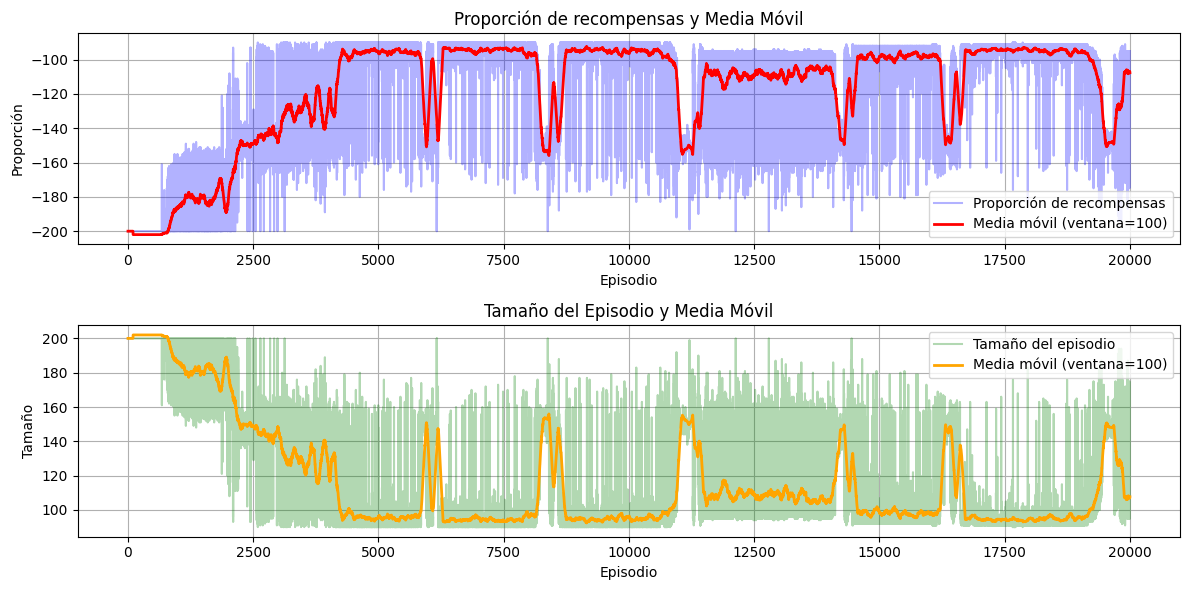

In [ ]:
plot(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)


En la primera gráfica se aprecia el cómo poco a poco va mejorando sus soluciones hasta llegar al episodio 5000 para llegar a sus recompensas máximas. Aunque el aprendizaje es algo inestable, pero aun con todo parece que alcanza una política óptima y excelentes recompensas. Con el tamaño de los episodios pasa algo similar, empieza terminando por truncamiento y poco a poco alcanza un tamaño más pequeño, aunque también se aprecia cierta inestabilidad.

Generamos el video con la politica optima

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
pi, actions, frames = pi_star_from_Q(tcenv, agent.Q)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

Política óptima obtenida
 {((8, 10), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9)): 0, ((8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 9), (8, 8), (8, 8), (8, 9), (8, 8), (7, 8), (7, 9), (7, 9), (7, 8)): 0, ((8, 9), (8, 8), (8, 8), (8, 8), (8, 9), (7, 8), (7, 8), (7, 9), (7, 8), (7, 8)): 0, ((8, 9), (8, 8), (8, 8), (8, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (8, 8), (8, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (8, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 8)): 0, ((8, 8), (7, 8), (7, 7), (7, 7), (7, 8), (7, 8), (7, 7), (7, 8), (7, 8), (7, 7)): 0, ((7, 8), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7)): 0, ((7, 8), (7, 7), (7, 7), (7, 7), (7, 8), (7, 7), (7, 7), (7, 8), (7, 7), (6, 7)): 0, ((7, 8), (7, 7), (7, 7), (7, 7), (7, 

In [ ]:
create_gif(frames, "Sarsa-MountainCar.mp4", fps=24)  # saves the GIF locally

Moviepy - Building video Sarsa.mp4.
Moviepy - Writing video Sarsa.mp4



Moviepy - Done !
Moviepy - video ready Sarsa.mp4


Al igual que Q learning la polución parece simplemente perfecta, no hace movimientos innecesarios y coge el impulso necesario. Por lo que la política final es óptima y eficiente.

# Conclusiones

Las conclusiones que podemos sacar son:
- Mountain Car es un problema más complejo que los realizados hasta ahora, debido a un espacio de observación continuo
- No podemos trabajar como hasta ahora es necesario aplicar discretizacion
- Usar tiling para discretizar el espacio de estados
- Con discretizacion podemos usar nuestros algoritmos
- Valorar algoritmos tabulares y de aproximación
- Ambos usando tiling
- Algoritmos tabulares como Sarsa y Q-Learning son excelentes para este problema y alcanzan las mejores soluciones
- Sarsa Semi Gradiente también es excelente para este problema, aunque algo peor que los anteriores. Por ende, algoritmos de aproximación lineales son también efectivos
- Algoritmos de aproximación no lineales como Deep Q learning presentan una política final excelente, aunque tardan en mejorar y aprender; sin embargo, también son útiles para el problema
- Algoritmos de monte Carlo que también son tabulares no son útiles y no logran mejorar ni aprender, esto se debe al realizar la actualización de Q tras cada episodio, el volver a recorrer episodios y el combinarlo con el uso de tiling da como resultado unos algoritmos incapaces de resolver el problema.